In [1]:
# Feature engineering and model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Classification models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

import vectorbt as vbt

# Custom imports to prevent clutter
from helper import get_ohlcv_data
from helper import calculate_triple_barrier_labels
from helper import calculate_train_performance
from helper import calculate_test_performance
from custom_transformers import *

In [33]:
def cusum_filter_positive_breaks_diff(price_series, threshold=None, volatility_lookback=50, volatility_multiplier=4.0):
    """
    CUSUM Filter to detect significant positive structural breaks in a price series using price differences, 
    with an option to dynamically set the threshold based on recent volatility.

    :param price_series: pd.Series, series of prices
    :param threshold: float or None, the fixed threshold for detecting a significant positive change. If None,
                      the threshold is set dynamically based on recent volatility.
    :param volatility_lookback: int, the lookback period for volatility calculation if the threshold is set dynamically
    :param volatility_multiplier: float, multiplier for the dynamic threshold based on recent volatility
    :return: pd.DatetimeIndex, indices of the detected significant positive structural breaks
    """
    # Calculate price differences
    price_diff = price_series.diff().dropna()

    # Determine the dynamic threshold based on volatility if not provided
    if threshold is None:
        rolling_volatility = price_diff.rolling(window=volatility_lookback, min_periods=1).std()
        dynamic_threshold = rolling_volatility * volatility_multiplier
    else:
        dynamic_threshold = pd.Series([threshold] * len(price_diff), index=price_diff.index)

    # Initialize the positive CUSUM series
    cusum_pos = pd.Series(0.0, index=price_diff.index)

    # List to store indices of significant positive structural breaks
    events = []

    for i in range(1, len(price_diff)):
        # Update positive CUSUM series with price differences
        cusum_pos.iloc[i] = max(0, cusum_pos.iloc[i-1] + price_diff.iloc[i])

        # Check if the positive CUSUM series exceeds the threshold
        if cusum_pos.iloc[i] > dynamic_threshold.iloc[i]:
            events.append(price_diff.index[i])
            cusum_pos.iloc[i] = 0  # Reset positive CUSUM series

    return pd.DatetimeIndex(events)

# Example usage:
# price_series = pd.Series([your price data here])
# events = cusum_filter_positive_breaks_diff(price_series, threshold=None)  # Using a dynamic threshold


In [86]:
# Specify window sizes for rolling min-max and z-score scaling
window_sizes = [6, 12, 24]

# Specify the symbol ID
symbol_id = 'BTC_USD_COINBASE'

# Pipeline for feature engineering and modeling
feature_engineering_pipeline = Pipeline([

    # Add block-based features to the dataset
    # ('block_features', BlockFeatures()),

    # Add transaction-based features to the dataset
    ('transaction_features', TransactionFeatures()),

    # Add transfer-based features to the dataset
    # ('transfer_features', TransferFeatures()),

    # Add tick-based features to the dataset
    ('tick_features', TickFeatures(symbol_id = symbol_id)),

    # Add order book-based features to the dataset
    # ('order_book_features', OrderBookFeatures(symbol_id = symbol_id)),

    # Add wallet-based features to the dataset
    ('wallet_features', WalletFeatures()),

    # Add rolling min-max scaled features to the dataset
    ('rolling_min_max_scaler', RollingMinMaxScaler(window_sizes)),

    # Add rolling z-score scaled features to the dataset
    ('rolling_z_score_scaler', RollingZScoreScaler(window_sizes)),

    # Add price-based features to the dataset
    ('price_features', PriceFeatures()),

    # Add more feature engineering steps here
    # ...
    # ...

    # Clean NaN/infinity values from the dataset
    ('fill_nan', FillNaN()),

    # Add lagged features to the dataset
    ('lag_features', LagFeatures(lags = [1, 2, 3])),

    # Add time-based features to the dataset
    ('time_features', TimeFeatures())
])

In [87]:
base, quote, exchange = symbol_id.split('_')

ohlcv_1h = get_ohlcv_data(base, quote, exchange)
ohlcv_1h.head()

,price_open,price_high,price_low,price_close,volume_traded
time_period_end,,,,,
2015-01-14 17:00:00,173.93,197.97,110.2,185.91,1.050000
2015-01-14 18:00:00,173.93,197.97,110.2,185.91,1.050000
2015-01-14 19:00:00,186.00,186.00,186.0,186.00,0.015362
2015-01-14 20:00:00,186.00,188.00,120.0,120.00,0.264638
2015-01-14 21:00:00,186.00,188.00,120.0,120.00,0.264638


In [116]:
# TODO:Test out different filters


# Run feature engineering pipeline
X = feature_engineering_pipeline.fit_transform(ohlcv_1h)

# Calculate triple-barrier labels from OHLCV data
y = calculate_triple_barrier_labels(ohlcv_1h, atr_window = 24, max_holding_time = 24)

# Z-score filter
# X['price_close_z_score_24h'] = (X['price_close'] - X['price_close'].rolling(24).mean()) / X['price_close'].rolling(24).std()
# X['price_close_z_score_24h'].fillna(0, inplace = True)

# CUSUM filter
# events = cusum_filter_positive_breaks_diff(X['price_close'], threshold = None, volatility_lookback = 24 * 7, volatility_multiplier = 2.5)
# X['cusum_filter'] = 0
# X.loc[events, 'cusum_filter'] = 1

# We only want to make predictions on data that satisfies the CUSUM filter
# X = X[X['cusum_filter'] == 1]

# RSI filter
X['rsi'] = vbt.RSI.run(X['price_close'], window = 24 * 7).rsi
X['rsi_filter'] = 0
X.loc[X['rsi'] >= 50, 'rsi_filter'] = 1

# We only want to make predictions on data that satisfies the RSI filter
X = X[X['rsi_filter'] == 1]

# We only want to make predictions on data that satisfies the Z-score filter
# X = X[X['price_close_z_score_24h'].abs() >= 1]

# Align X and y
X = X[X.index.isin(y.index)]
y = y[y.index.isin(X.index)]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size = 0.2, random_state = 42)

In [117]:
print('Y train distribution:')
print(y_train.value_counts(normalize = True))
print()
print('Y test distribution:')
print(y_test.value_counts(normalize = True))

Y train distribution:
-1.0    0.561101
 1.0    0.438899
dtype: float64

Y test distribution:
-1.0    0.585497
 1.0    0.414503
dtype: float64


In [120]:
# Date range of train and test sets
train_start_date = X_train.index[0]
train_end_date = X_train.index[-1]
test_start_date = X_test.index[0]
test_end_date = X_test.index[-1]

print('Train set date range:', train_start_date, '-', train_end_date)
print('Test set date range:', test_start_date, '-', test_end_date)

Train set date range: 2018-06-01 20:00:00 - 2021-03-09 02:00:00
Test set date range: 2021-03-09 03:00:00 - 2021-11-15 14:00:00


In [121]:
%%time

# Grid search parameters for Random Forest
param_grid_rf = {
    'n_estimators': [50], # Number of trees
    'max_depth': [10], # Maximum depth of each tree
    'min_samples_split': [2], # Minimum number of samples required to split a node
    'min_samples_leaf': [2], # Minimum number of samples required at each leaf node
    'max_features': ['sqrt'], # Random number/percentage of features to consider at each split
}

# Random Forest classifier
rf = RandomForestClassifier(bootstrap = False, random_state = 9 + 10) # Set random state for reproducibility

# Initialize grid search
grid_search = GridSearchCV(
    rf, 
    param_grid_rf, 
    cv = TimeSeriesSplit(n_splits = 5), 
    scoring = 'f1',
    verbose = 1, 
    n_jobs = -1
)

# Execute grid search
grid_search.fit(X_train, y_train)

# Best hyperparameters and best model from grid search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print()
print('Best parameters: ', best_params)
print()

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best parameters:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}

CPU times: user 14.8 s, sys: 187 ms, total: 15 s
Wall time: 29.2 s


Train Classification Report

              precision    recall  f1-score   support

        -1.0       0.89      0.98      0.94      7521
         1.0       0.97      0.85      0.91      5883

    accuracy                           0.92     13404
   macro avg       0.93      0.92      0.92     13404
weighted avg       0.93      0.92      0.92     13404

Train Accuracy:  0.9235
Train Precision:  0.9282
Train Recall:  0.9235
Train F1 Score:  0.9226


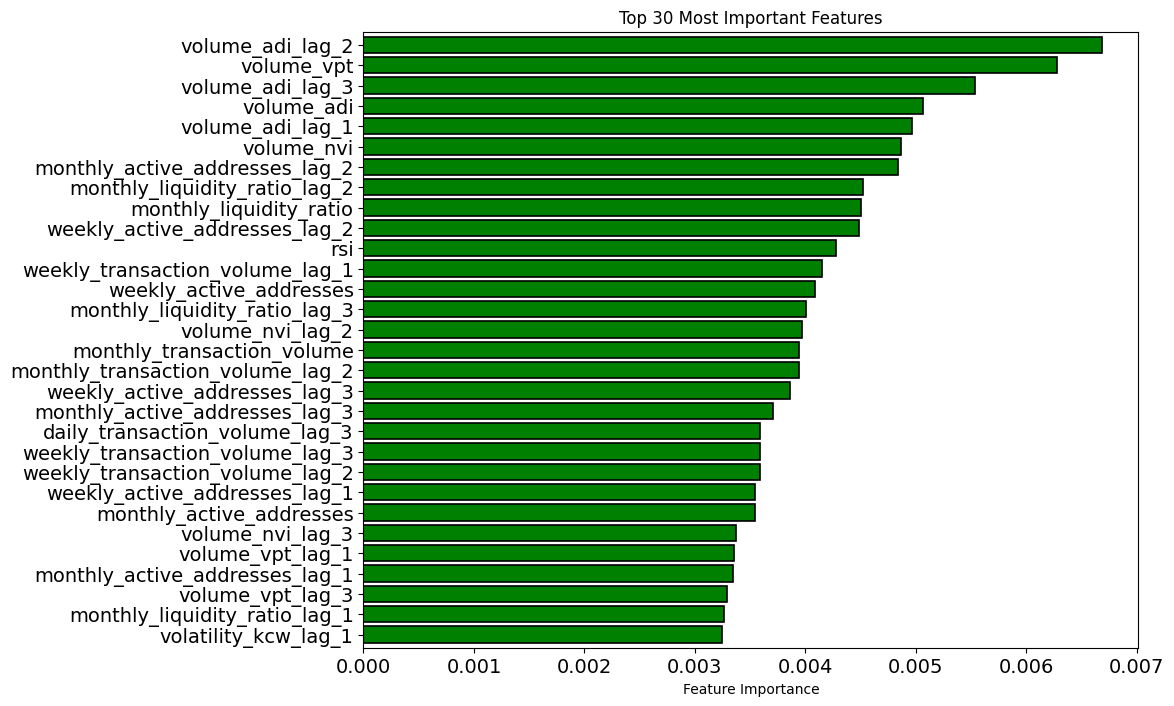

In [122]:
calculate_train_performance(X_train, y_train, best_model)

Test Classification Report

              precision    recall  f1-score   support

        -1.0       0.60      0.36      0.45      1962
         1.0       0.42      0.65      0.51      1389

    accuracy                           0.48      3351
   macro avg       0.51      0.51      0.48      3351
weighted avg       0.52      0.48      0.48      3351

Test Accuracy:  0.4834
Test Precision:  0.5236
Test Recall:  0.4834
Test F1 Score:  0.4767


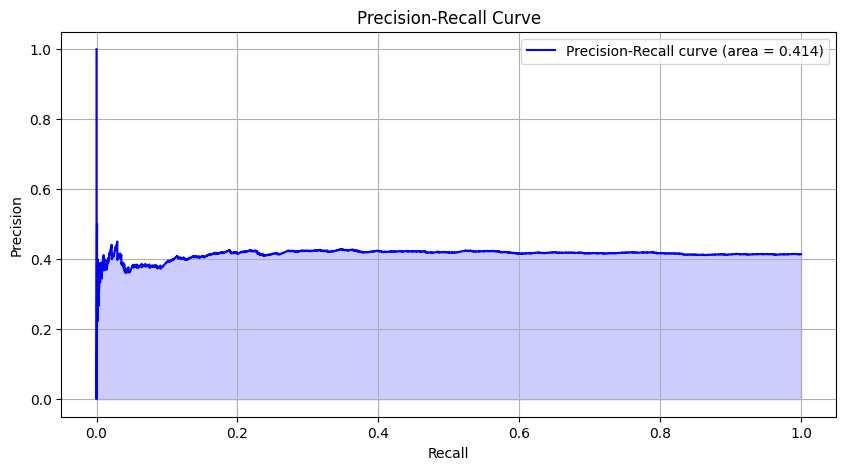

In [123]:
price_data = ohlcv_1h[ohlcv_1h.index.isin(X_test.index)]
atr_data = vbt.ATR.run(price_data.price_high, price_data.price_low, price_data.price_close, window = 24).atr

calculate_test_performance(X_test, y_test, best_model, price_data, atr_data)

In [59]:
len(close), len(cusum_events)

(66103, 3866)

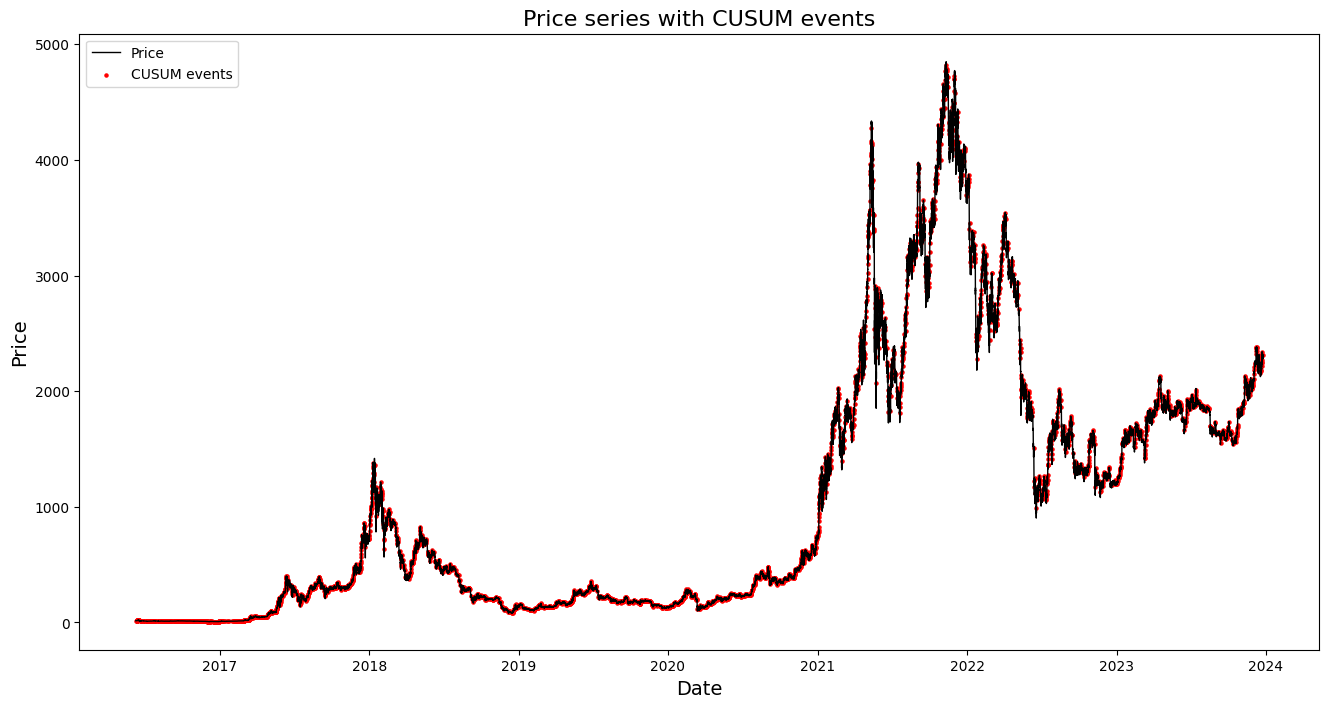

In [60]:
# Plot the price series with CUSUM events
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize = (16, 8))

ax.plot(close, color = 'black', linewidth = 1.0, label = 'Price')
ax.scatter(cusum_events, close.loc[cusum_events], color = 'red', label = 'CUSUM events', s = 5)

ax.set_title('Price series with CUSUM events', fontsize = 16)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylabel('Price', fontsize = 14)
ax.legend(loc = 'upper left')

plt.show()